In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import matplotlib.pyplot as plt
import bangla_nlp
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

g:\OneDrive - northsouth.edu\CODES\PROJECTS\PROJECT - Bullishield Models\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df=pd.read_csv('Bengali hate speech .csv')
df.head()

,sentence,hate,category
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports


In [3]:
print("Hate-Non hate distribution")
df['hate'].value_counts()

Hate-Non hate distribution


hate
0    20000
1    10000
Name: count, dtype: int64

In [4]:
df_filtered=df[df['hate']==1]
print("Number of hate comments in every category")
df_filtered['category'].value_counts()

Number of hate comments in every category


category
crime                      2000
entertainment              1627
sports                     1601
religion                   1570
Meme, TikTok and others    1563
politics                    886
celebrity                   753
Name: count, dtype: int64

In [5]:

# remove punctuations
df['clean_punctuation']=df['sentence'].apply(bangla_nlp.clean_punctuations)
df['clean_emoji']=df['clean_punctuation'].apply(bangla_nlp.clean_emoji)
df['clean_text']=df['clean_emoji'].apply(bangla_nlp.clean_url_and_email)
df['clean_text']=df['clean_text'].apply(bangla_nlp.clean_digits)
drop_columns=['clean_punctuation','clean_emoji']
df.drop(columns=drop_columns,inplace=True)
df.head()


,sentence,hate,category,clean_text
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,যত্তসব পাপন শালার ফাজলামী
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,পাপন শালা রে রিমান্ডে নেওয়া দরকার
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,তুই তো শালা গাজা খাইছচ তুর মার হেডায় খেলবে সাকিব


In [6]:
df['tokenized_words']=df['clean_text'].apply(bangla_nlp.word_tokenize_texts)
df.head()

,sentence,hate,category,clean_text,tokenized_words
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,যত্তসব পাপন শালার ফাজলামী,"[যত্তসব, পাপন, শালার, ফাজলামী]"
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,পাপন শালা রে রিমান্ডে নেওয়া দরকার,"[পাপন, শালা, রে, রিমান্ডে, নেওয়া, দরকার]"
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,"[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,..."
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,"[শালা, লুচ্চা, দেখতে, পাঠার, মত, দেখা, যায়]"
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,তুই তো শালা গাজা খাইছচ তুর মার হেডায় খেলবে সাকিব,"[তুই, তো, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, ..."


In [7]:
df['no_stopword_tokenized_words']=df['tokenized_words'].apply(bangla_nlp.remove_stopwords_from_tokens)
df.head()

,sentence,hate,category,clean_text,tokenized_words,no_stopword_tokenized_words
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,যত্তসব পাপন শালার ফাজলামী,"[যত্তসব, পাপন, শালার, ফাজলামী]","[যত্তসব, পাপন, শালার, ফাজলামী]"
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,পাপন শালা রে রিমান্ডে নেওয়া দরকার,"[পাপন, শালা, রে, রিমান্ডে, নেওয়া, দরকার]","[পাপন, শালা, রে, রিমান্ডে, দরকার]"
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,"[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,...","[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,..."
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,"[শালা, লুচ্চা, দেখতে, পাঠার, মত, দেখা, যায়]","[শালা, লুচ্চা, পাঠার, মত, যায়]"
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,তুই তো শালা গাজা খাইছচ তুর মার হেডায় খেলবে সাকিব,"[তুই, তো, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, ...","[তুই, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, খেলব..."


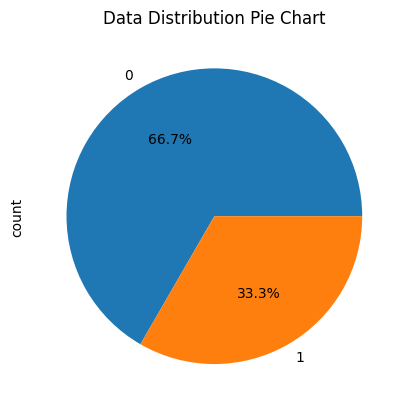

In [8]:
value_counts=df['hate'].value_counts()
# Plot a pie chart
value_counts.plot.pie(autopct='%.1f%%')
# Add a title
plt.title("Data Distribution Pie Chart")
# Show the plot
plt.show()

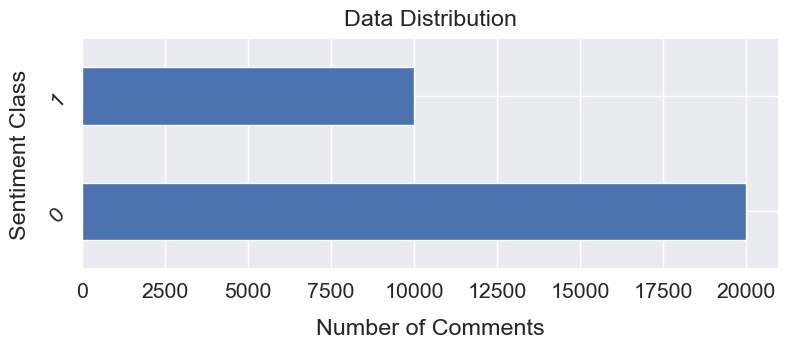

In [9]:
sns.set(font_scale=1.4)
df['hate'].value_counts().plot(kind='barh', figsize=(9, 3))
plt.xlabel("Number of Comments", labelpad=12)
plt.ylabel("Sentiment Class", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Data Distribution", y=1.02);

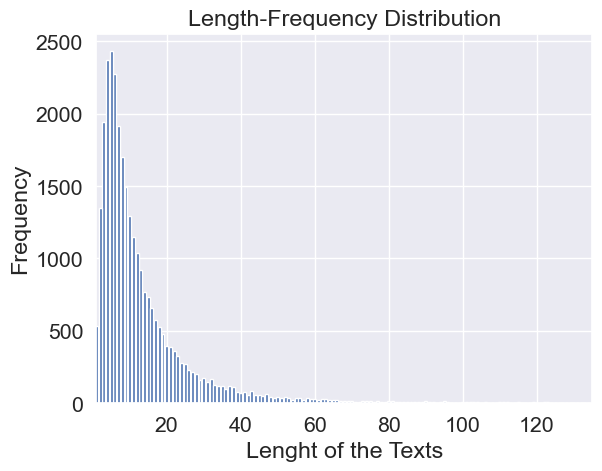

Maximum Length of a review: 537
Minimum Length of a review: 1
Average Length of a reviews: 15.0


In [10]:
# Calculate the Review of each of the Review
df['ReviewLength'] = df.sentence.apply(lambda x:len(x.split()))
frequency = dict()
for i in df.ReviewLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 135)
# in this notbook color is not working but it should work.
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a review: {max(df.ReviewLength)}")
print(f"Minimum Length of a review: {min(df.ReviewLength)}")
print(f"Average Length of a reviews: {round(np.mean(df.ReviewLength),0)}")

In [11]:
# count the number of samples in each class
class_counts = df['hate'].value_counts()
print(class_counts)

hate
0    20000
1    10000
Name: count, dtype: int64


In [12]:
df['clean_string_words']=df['no_stopword_tokenized_words'].apply(' '.join)
df.head()

,sentence,hate,category,clean_text,tokenized_words,no_stopword_tokenized_words,ReviewLength,clean_string_words
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,যত্তসব পাপন শালার ফাজলামী,"[যত্তসব, পাপন, শালার, ফাজলামী]","[যত্তসব, পাপন, শালার, ফাজলামী]",4,যত্তসব পাপন শালার ফাজলামী
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,পাপন শালা রে রিমান্ডে নেওয়া দরকার,"[পাপন, শালা, রে, রিমান্ডে, নেওয়া, দরকার]","[পাপন, শালা, রে, রিমান্ডে, দরকার]",6,পাপন শালা রে রিমান্ডে দরকার
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,"[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,...","[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,...",20,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ একটা দে...
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,"[শালা, লুচ্চা, দেখতে, পাঠার, মত, দেখা, যায়]","[শালা, লুচ্চা, পাঠার, মত, যায়]",7,শালা লুচ্চা পাঠার মত যায়
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,তুই তো শালা গাজা খাইছচ তুর মার হেডায় খেলবে সাকিব,"[তুই, তো, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, ...","[তুই, শালা, গাজা, খাইছচ, তুর, মার, হেডায়, খেলব...",9,তুই শালা গাজা খাইছচ তুর মার হেডায় খেলবে সাকিব


In [13]:
# Split dataset into training and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


In [14]:
# Tokenize the data
def tokenize_texts(texts, max_length):
    tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')
    tokenized_texts = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return tokenized_texts

max_length=128

train_tokenized_texts = tokenize_texts(train_data['clean_string_words'].tolist(), max_length)
test_tokenized_texts = tokenize_texts(train_data['clean_string_words'].tolist(), max_length)


In [15]:
# Prepare train and test inputs and labels
train_inputs = {
    'input_ids': train_tokenized_texts['input_ids'],
    'attention_mask': train_tokenized_texts['attention_mask']
}

train_labels = torch.tensor(train_data['hate'].values,dtype=torch.float32).unsqueeze(1)

test_inputs = {
    'input_ids': test_tokenized_texts['input_ids'],
    'attention_mask': test_tokenized_texts['attention_mask']
}

test_labels = torch.tensor(test_data['hate'].values,dtype=torch.float32).unsqueeze(1)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [39]:
def calculate_class_weights(y):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_weights = {}

    for class_label, class_count in zip(unique_classes, class_counts):
        class_weight = total_samples / (2.0 * class_count)
        class_weights[class_label] = class_weight

    return class_weights

In [41]:
# Convert class weights to a tensor
class_weights_dict = calculate_class_weights(train_labels.numpy())
print(class_weights_dict)
class_weights = torch.tensor([class_weights_dict[label.item()] for label in train_labels])
print(class_weights)

{0.0: 0.7499062617172854, 1.0: 1.5003750937734435}
tensor([0.7499, 1.5004, 0.7499,  ..., 1.5004, 0.7499, 0.7499],
       dtype=torch.float64)


In [35]:
# Bangla Bert model
class CyberBullyingClassifier(nn.Module):
    def __init__(self):
        super(CyberBullyingClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('sagorsarker/bangla-bert-base')
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        probability = self.sigmoid(logits)
        return probability

In [36]:
# Create model instance
model = CyberBullyingClassifier()
model.to(device)

CyberBullyingClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [42]:
# Defining optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 100
total_steps = len(train_inputs['input_ids']) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Update the loss function to use class weights
criterion = nn.BCELoss(weight=class_weights)


In [44]:
def train_model(model, train_inputs, train_labels, criterion, optimizer, scheduler, device, batch_size=32, epochs=epochs):
    model.train()
    best_loss=float('inf')
    wait=0
    epsilon=1e-8
    patience_counter=3
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(0, len(train_inputs['input_ids']), batch_size):
            inputs = {key: val[i:i+batch_size].to(device) for key, val in train_inputs.items()}
            labels = train_labels[i:i+batch_size].to(device)

            optimizer.zero_grad()

            outputs = model(**inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * batch_size

        epoch_loss = running_loss / len(train_labels)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')
        
        if epoch_loss<best_loss-epsilon:
            best_loss=epoch_loss
            wait=0
        else:
            wait+=1
            if wait >=patience_counter:
                print(f'Stopping early at epoch {epoch+1} due to insignificant loss change.')
                break

# Training the model
train_model(model, train_inputs, train_labels, criterion, optimizer, scheduler, device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

In [ ]:
# saving the model
torch.save(model.state_dict(), '/home/ara2/Desktop/Farhan_Bullishield_CSE498R/Created Models/bangla_bert_class_imbalanced_wieghts.pth')